# 设计哲学

连续吸引子神经网络（CANNs）Python 库设计理念手册，通过了解各个模块的功能来快速上手本项目。

本库围绕CANNs提供统一的高级 API，使用户可以轻松加载、分析和训练最先进的 CANN 架构，从而帮助研究人员和开发者快速开展实验并部署类脑解决方案。

## 模块总览
- `model`
  本库的内置模型模块。
  - `basic`
    基础CANNs模型及其各个变体。
  - `brain_inspired`
    各种类脑模型。
  - `hybrid`
    CANN与ANN或其他的混合模型。
- `task`
  针对CANN的任务模块，包含任务的生成、保存、读取、导入、可视化等功能。
- `analyzer`
  分析模块，主要为可视化作图。
  - `model analyzer`
    专注于对CANN模型进行分析，包括能量景观、发放率、调谐曲线等。
  - `data analyzer`
    专注于实验数据的CANN分析或虚拟RNN模型的动力学分析
- `trainer`
  训练模块，提供统一的学习与预测流程。
- `pipeline`
  通过将上述模块组合，形成一套端到端的流程，使得对于某些需求可以最简化调用，用户友好。

## 各模块详解


### `models`

#### 总览
模型模块实现不同维度的CANN基础模型及其变体，脑启发模型以及CANN混合模型。该模块是本库的基础，可以与其他的模块来进行交互来实现各种场景的应用。

这里根据不同的模型类型进行分类：

- Basic Models (canns.models.basic)
  基础的CANNs模型及其各个变体。
- Brain-Inspired Models (canns.models.brain_inspired)
  类脑模型。
- Hybrid Models (canns.models.hybrid)
  CANN与ANN或其他的混合模型。

在这里主要依赖[Brain simulation ecosystem](https://brainmodeling.readthedocs.io/index.html)中的[brainstate](https://brainstate.readthedocs.io)来实现各个模型。`brainstate` 是 Brain Simulation Ecosystem 中面向动力系统的核心框架，底层基于 JAX/BrainUnit。它提供 `brainstate.nn.Dynamics` 抽象、`State`/`HiddenState`/`ParamState` 状态容器以及 `brainstate.environ` 统一的时间步长管理，与 `brainstate.compile.for_loop`、`brainstate.random` 等工具一起，让我们可以写出既可 JIT 编译又支持自动微分的神经网络动力学。借助这些接口，CANN 模型只需描述变量与更新方程，时间推进、并行化和随机数管理都由 `brainstate` 负责，从而显著降低实现成本。

#### 用法示例
以下示例概括了在库中使用模型的完整流程，可分别参考 `examples/cann/cann1d_oscillatory_tracking.py`、`examples/cann/cann2d_tracking.py` 与 `examples/brain_inspired/hopfield_train.py`：

In [1]:
import brainstate as bst
from canns.models.basic import CANN1D, CANN2D
from canns.task.tracking import SmoothTracking1D, SmoothTracking2D
from canns.analyzer.plotting import (
    PlotConfigs,
    energy_landscape_1d_animation,
    energy_landscape_2d_animation,
)

bst.environ.set(dt=0.1)

# 创建1D CANN实例并初始化状态
cann = CANN1D(num=512)  # 512个神经元
cann.init_state()       # 初始化神经网络状态

# 这里使用SmoothTracking1D的task，在之后的章节会具体介绍
task_1d = SmoothTracking1D(
    cann_instance=cann,
    Iext=(1.0, 0.75, 2.0, 1.75, 3.0),
    duration=(10.0,) * 4,
    time_step=bst.environ.get_dt(),
)
task_1d.get_data()  # 生成任务数据

# 写一个step函数，传入stimulus，运行CANN1D实例
def step_1d(_, stimulus):
    cann(stimulus)                          # 使用传入的stimulus更新CANN状态
    return cann.u.value, cann.inp.value     # 返回神经元膜电位和输入

us, inputs = bst.compile.for_loop(step_1d, task_1d.run_steps, task_1d.data) # 使用brainstate的for_loop编译step函数

<SmoothTracking1D> Generating Task data: 400it [00:00, 2409.20it/s]


对于脑启发模型，可参考下述 Hopfield 示例（见 `examples/brain_inspired/hopfield_train.py`），在噪声图像上完成模式恢复：

In [ ]:
from canns.models.brain_inspired import AmariHopfieldNetwork
from canns.trainer import HebbianTrainer

# 创建 Amari Hopfield 网络实例并初始化状态
model = AmariHopfieldNetwork(num_neurons=128 * 128, asyn=False, activation='sign')
model.init_state()  # 初始化神经网络状态

trainer = HebbianTrainer(model) # 创建 HebbianTrainer 实例, 在之后的章节会具体介绍
trainer.train(train_patterns)  # train_patterns: List[np.ndarray] 形状为 (N,), 进行训练
denoised = trainer.predict_batch(noisy_patterns, show_sample_progress=True)

#### 拓展开发指南
因为基础实现完全依赖 `brainstate`，开发者在拓展模型时建议同步查阅官方文档：https://brainstate.readthedocs.io ，重点掌握 `nn.Dynamics` 的状态注册方式、`environ.set/get_dt` 的时间管理、`compile.for_loop` 的批量执行范式，以及 `ParamState`/`HiddenState` 的使用习惯。这些概念有助于写出与现有模型兼容的数值结构和 API。

##### 对于基础模型

每个模型都继承自`canns.models.basic.BasicModel`或`canns.models.basic.BasicModelGroup`类，并实现了以下主要方法：

在基础模型中需要完成的主要工作：

- 继承 `canns.models.basic.BasicModel` 或 `BasicModelGroup`，在 `__init__` 中调用父类构造（例如 `super().__init__(math.prod(shape), **kwargs)`）并保存好 `shape`、`varshape` 等维度信息；
- 实现 `make_conn()` 生成连接矩阵，并在构造函数里赋值给 `self.conn_mat`（可参考 `src/canns/models/basic/cann.py` 中的高斯核实现）；
- 实现 `get_stimulus_by_pos(pos)`，根据特征空间的位置返回外部刺激，供任务模块调用；
- 在 `init_state()` 注册 `brainstate.HiddenState`/`State`（常见的有 `self.u`、`self.r`、`self.inp`），确保更新函数能够直接读写；
- 在 `update(inputs)` 中写出单步动力学，记得乘以 `brainstate.environ.get_dt()` 维持数值稳定；
- 需要暴露诊断量或轴信息时，通过属性/方法返回（如 `self.x`、`self.rho`），供任务、分析器和流水线重用。

##### 对于脑启发模型

每个模型都继承自`canns.models.brain_inspired.BrainInspiredModel`或`canns.models.brain_inspired.BrainInspiredModelGroup`类，并实现了

若要扩展脑启发模型（继承 `BrainInspiredModel` 或 `BrainInspiredModelGroup`），请确保：

- 在 `init_state()` 中至少注册状态向量（默认 `self.s`）和连接权重 `self.W`，其中 `self.W` 建议使用 `brainstate.ParamState` 以便 Hebbian 学习直接写入；
- 如果权重属性名称不是 `W`，重写 `weight_attr` 以便 `HebbianTrainer` 能找到；
- 实现 `update(...)` 与 `energy` 属性，确保训练器可以运行通用预测循环并判定收敛；
- 需要定制 Hebbian 规则时实现 `apply_hebbian_learning(patterns)`，否则可以完全依赖训练器的通用实现；
- 若模型支持动态尺寸调整，可重写 `resize(num_neurons, preserve_submatrix=True)`，参考 `src/canns/models/brain_inspired/hopfield.py` 中的做法。

##### 对于混合模型

在未来实现，待定。

### `task`

#### 总览
任务模块主要用于生成、保存、读取、导入和可视化各种CANN任务。该模块提供了多种预定义的任务类型，并允许用户自定义任务以满足特定需求。


#### 用法示例
以一维跟踪任务为例（见 `examples/cann/cann1d_oscillatory_tracking.py`）：

In [20]:
from canns.task.tracking import SmoothTracking1D
from canns.models.basic import CANN1D
from canns.analyzer.plotting import energy_landscape_1d_animation, PlotConfigs

# 创建 SmoothTracking1D 任务
task_st = SmoothTracking1D(
    cann_instance=cann,
    Iext=(1., 0.75, 2., 1.75, 3.),   # 外部输入强度，对于SmoothTracking1D任务，这里表示不同阶段的起始与结束输入强度，对应着下面的duration
    duration=(10., 10., 10., 10.),   # 每个阶段的持续时间，这里表示任务总共分为4个阶段，每个阶段持续10.0时间单位
    time_step=bst.environ.get_dt(),
)
task_st.get_data()  # 生成任务数据

task_st.data  # 任务数据，包括时间序列和对应的外部输入

<SmoothTracking1D> Generating Task data: 400it [00:00, 9206.62it/s]


array([[0.10189284, 0.09665093, 0.09165075, ..., 0.11314222, 0.10738649,
        0.10189275],
       [0.10079604, 0.09560461, 0.09065294, ..., 0.11193825, 0.10623717,
        0.10079593],
       [0.09970973, 0.0945684 , 0.08966482, ..., 0.11074577, 0.10509886,
        0.09970973],
       ...,
       [9.72546482, 9.68417931, 9.64015198, ..., 9.79967213, 9.76397419,
        9.72546482],
       [9.76497078, 9.72653675, 9.68532467, ..., 9.83337116, 9.80059338,
        9.76497078],
       [9.80151176, 9.76596642, 9.72760582, ..., 9.86403942, 9.8342123 ,
        9.80151081]], shape=(400, 512))

`SmoothTracking1D`/`SmoothTracking2D` 会自动根据关键点生成平滑轨迹，`task.data` 与 `task.Iext_sequence` 可直接喂给模型或分析器。

所有任务都继承了基类的 `save_data`/`load_data` 方法，便于重复实验：

In [21]:
task.save_data("outputs/tracking_task.npz")
# ... 稍后或在另一台机器上
restored = SmoothTracking1D(
    cann_instance=cann_model,
    Iext=(1.0, 0.8, 2.2, 1.5),
    duration=(8.0,) * 3,
    time_step=bst.environ.get_dt(),
)
restored.load_data("outputs/tracking_task.npz")

Data successfully saved to: outputs/tracking_task.npz
Data successfully loaded from: outputs/tracking_task.npz


当 `self.data` 是 dataclass（如 `SpatialNavigationData`）时，基类会自动拆分字段保存，并在读取时重新构造结构化对象。

`SpatialNavigationTask` 既可以自生成轨迹，也支持导入实验数据。具体用法可以参考 `examples/cann/theta_sweep_grid_cell_network.py` 导入实验数据轨迹可以参考 `examples/cann/import_external_trajectory.py`：

Successfully imported trajectory data with 800 time steps
Spatial dimensions: 2D
Time range: 0.000 to 1.598 s
Mean speed: 1.395 units/s
Trajectory analysis saved to: trajectory.png


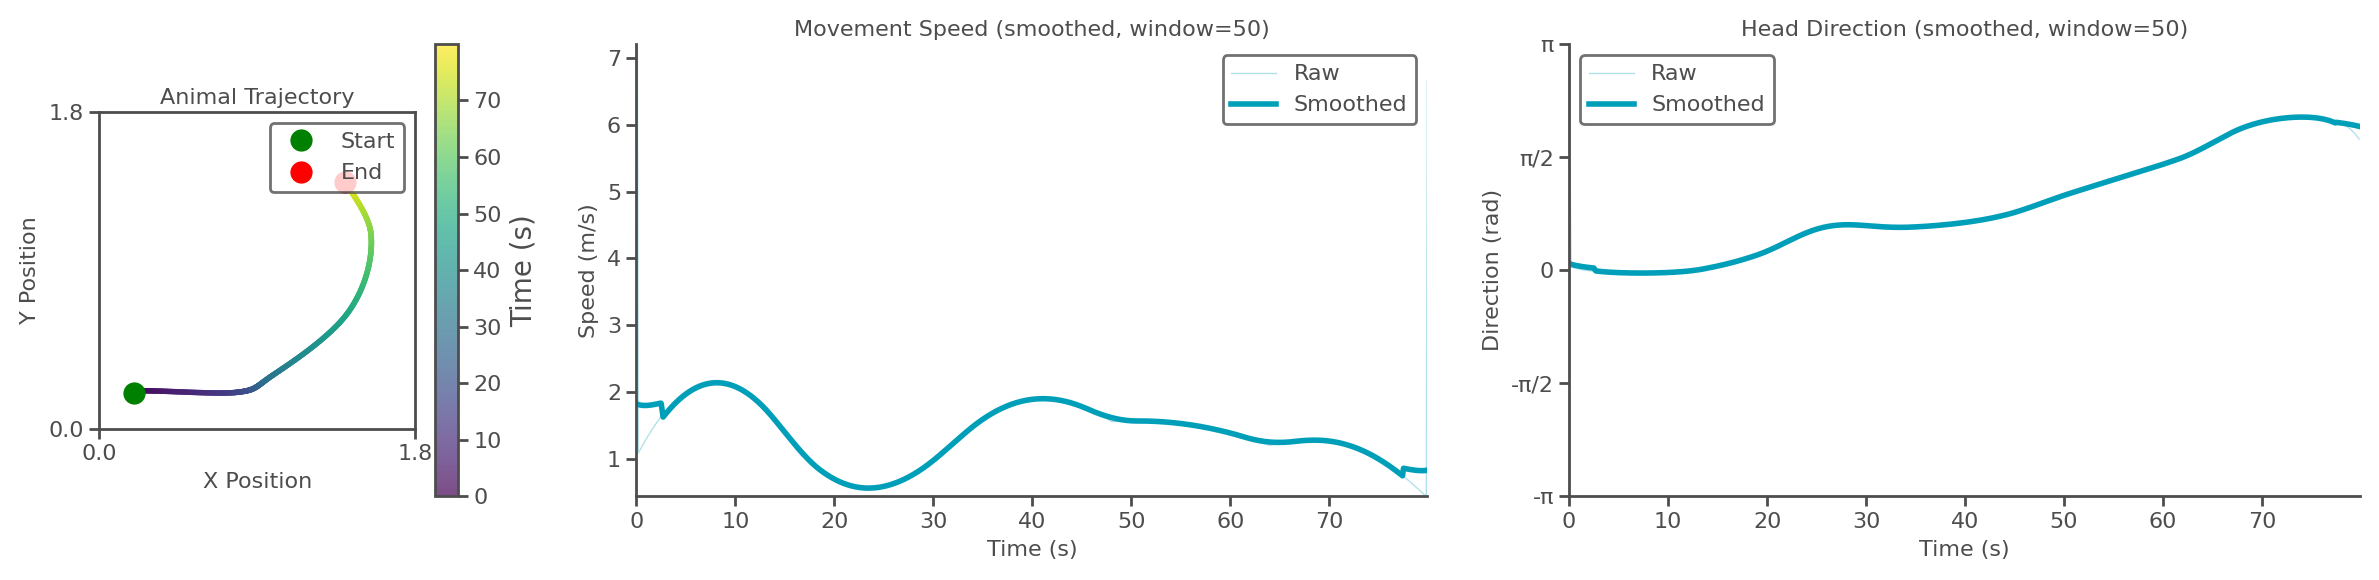

In [3]:
import numpy as np
import os
from canns.task.spatial_navigation import SpatialNavigationTask

# 使用numpy加载外部位置数据
data = np.load(os.path.join(os.getcwd(), "..", "..", "en", "notebooks", "external_trajectory.npz"))
positions = data["positions"]  # 形状为 (time_steps, 2)
times = data["times"]          # 形状为 (time_steps,)
simulate_time = times[-1] - times[0]
env_size = 1.8
dt = 0.1

task = SpatialNavigationTask(duration=simulate_time, width=env_size, height=env_size, dt=dt)
task.import_data(position_data=positions, times=times)  # 导入外部位置数据
task.calculate_theta_sweep_data()   # 计算 theta sweep数据
task.show_trajectory_analysis(save_path="trajectory.png", show=True, smooth_window=50) # 可视化轨迹分析

#### 拓展开发指南

用户可以通过继承`canns.task.Task`类来创建自定义任务。需要实现以下主要方法：

自定义任务时可遵循以下步骤：

- 继承 `canns.task.Task`，在构造函数中解析配置并（可选）指定 `data_class`；
- 实现 `get_data()` 生成或载入数据，并把结果写入 `self.data`（可以是 `numpy.ndarray` 或 dataclass）；
- 需要导入外部数据时提供 `import_data(...)` 等辅助方法，保持 `self.data` 的结构与 `get_data()` 输出一致；
- 实现 `show_data(show=True, save_path=None)`，给出最重要的可视化；
- 如需持久化直接复用基类 `save_data`/`load_data`，避免重复造轮子。

### `analyzer`

#### 总览

分析模块提供了丰富的工具，用于对CANN模型和实验数据进行深入分析和可视化。该模块分为两大类：模型分析和数据分析。

#### 用法

##### 模型分析

模型与任务配合后，可用 analyzer 生成可视化。例如延续 1D 跟踪流程：

In [ ]:
import brainstate
from canns.task.tracking import SmoothTracking1D
from canns.models.basic import CANN1D
from canns.analyzer.plotting import energy_landscape_1d_animation, PlotConfigs

brainstate.environ.set(dt=0.1)



# 创建 SmoothTracking1D 任务
task_st = SmoothTracking1D(
    cann_instance=cann,
    Iext=(1., 0.75, 2., 1.75, 3.),   # 外部输入强度，对于SmoothTracking1D任务，这里表示不同阶段的起始与结束输入强度，对应着下面的duration
    duration=(10., 10., 10., 10.),   # 每个阶段的持续时间，这里表示任务总共分为4个阶段，每个阶段持续10.0时间单位
    time_step=brainstate.environ.get_dt(),
)
task_st.get_data()  # 生成任务数据


# 写一个step函数，传入inputs，运行CANN1D实例
def run_step(t, inputs):
    cann(inputs)
    return cann.u.value, cann.inp.value

# 使用 brainstate.compile.for_loop 编译 step 函数
us, inps = brainstate.compile.for_loop(
    run_step,
    task_st.run_steps,  # 任务总共需要运行的时间步数
    task_st.data,       # 任务数据，这里为 SmoothTracking1D 生成的刺激
    pbar=brainstate.compile.ProgressBar(10) # 每10步更新一次进度条
)

# 配置并生成能量图动画
config = PlotConfigs.energy_landscape_1d_animation(
    time_steps_per_second=100,
    fps=20,
    title='Smooth Tracking 1D',
    xlabel='State',
    ylabel='Activity',
    repeat=True,
    save_path='smooth_tracking_1d.gif',
    show=False
)

# 生成能量图动画
energy_landscape_1d_animation(
    data_sets={'u': (cann.x, us), 'Iext': (cann.x, inps)},
    config=config
)

![smooth_tracking_1d](../../_static/smooth_tracking_1d.gif)

二维情形可调用 `energy_landscape_2d_animation(zs_data=...)` 输出二维活动热力图。

![smooth_tracking_1d](../../_static/CANN2D_encoding.gif)

##### 数据分析

实验数据分析流程可直接参考仓库中的两个脚本：

- `examples/experimental_cann1d_analysis.py`：`load_roi_data()` 读取示例 ROI 数据，随后利用 `bump_fits`、`create_1d_bump_animation` 拟合并生成 1D bump 动画；
- `examples/experimental_cann2d_analysis.py`：在 `embed_spike_trains` 生成埋入结果后，结合 UMAP 与 `plot_projection` 降维可视化，再调用 `tda_vis`、`decode_circular_coordinates` 和 `plot_3d_bump_on_torus` 完成拓扑分析与环面动画。

![bump_analysis](../../_static/bump_analysis_demo.gif)

![torus_bump](../../_static/torus_bump.gif)

#### 拓展开发指南

##### 模型分析

Analyzer 虽无统一基类，但推荐遵循 `src/canns/analyzer/plotting/config.py` 的配置范式：通过 `PlotConfig`/`PlotConfigs` 统一标题、坐标轴、动画帧率等参数，并在绘图函数中接收 `config` 对象。这种写法能让可视化接口保持一致，也方便用户定制默认样式。

##### 数据分析

同样，数据分析工具也没有统一的基类。用户可以根据具体需求创建自己的数据分析工具。

### `trainer`

#### 总览

训练模块提供了统一的接口，用于训练和评估类脑模型。暂时只提供hebbian learning的训练方式，未来会加入更多的类脑训练方法。

#### 用法

以 `HebbianTrainer` 为例，可参考 `examples/brain_inspired/hopfield_train.py`：

Processing samples: 100%|█████████████| 4/4 [00:04<00:00,  1.05s/it, sample=4/4]


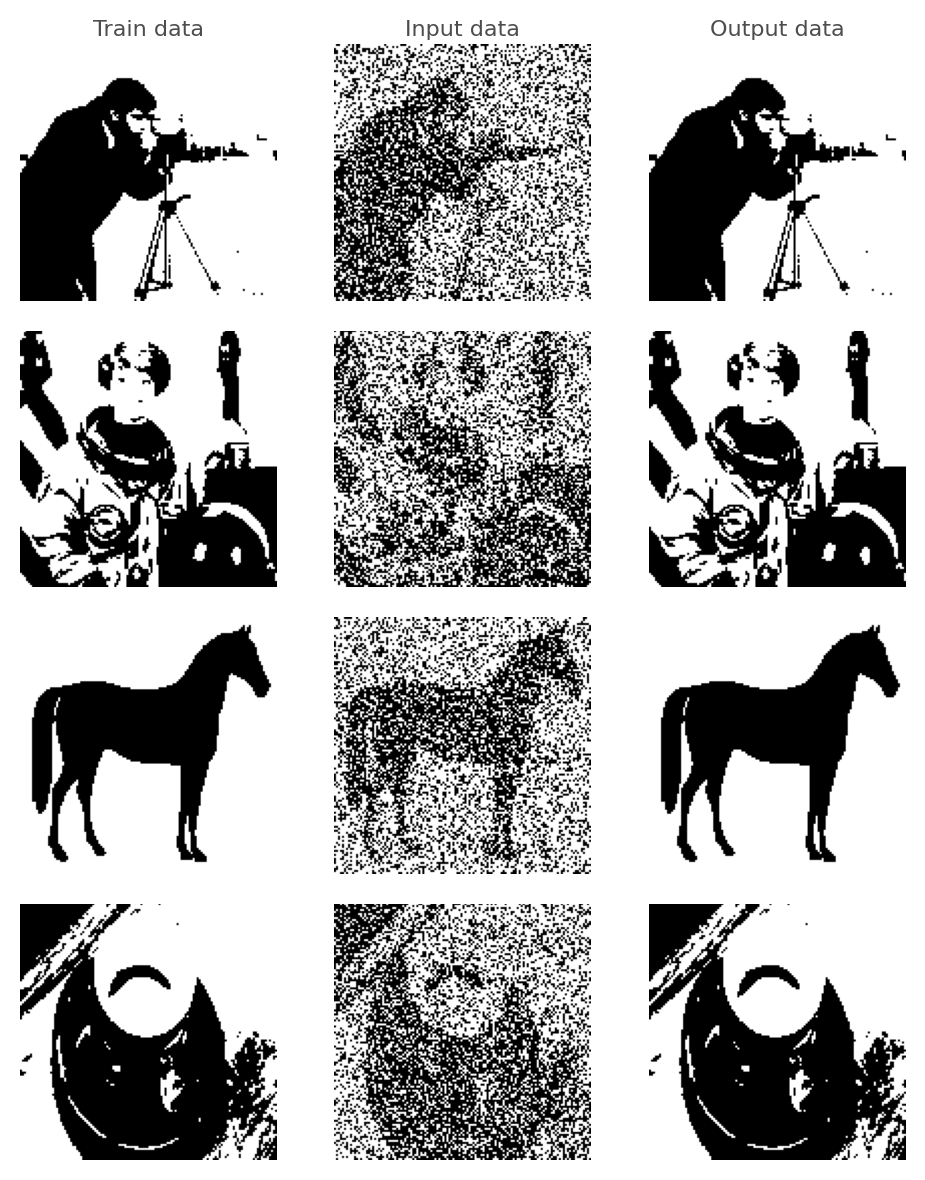

In [28]:
import numpy as np
import skimage.data
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import threshold_mean
from skimage.transform import resize

from canns.models.brain_inspired import AmariHopfieldNetwork
from canns.trainer import HebbianTrainer

np.random.seed(42)

def preprocess_image(img, w=128, h=128) -> np.ndarray:
    """Resize, grayscale (if needed), threshold to binary, then map to {-1,+1}."""
    if img.ndim == 3:
        img = rgb2gray(img)
    img = resize(img, (w, h), anti_aliasing=True)
    img = img.astype(np.float32, copy=False)
    thresh = threshold_mean(img)
    binary = img > thresh
    shift = np.where(binary, 1.0, -1.0).astype(np.float32)
    return shift.reshape(w * h)

# 从skimage加载训练数据
camera = preprocess_image(skimage.data.camera())
astronaut = preprocess_image(skimage.data.astronaut())
horse = preprocess_image(skimage.data.horse().astype(np.float32))
coffee = preprocess_image(skimage.data.coffee())

data_list = [camera, astronaut, horse, coffee]

# 创建 Amari Hopfield 网络实例并初始化状态
model = AmariHopfieldNetwork(num_neurons=data_list[0].shape[0], asyn=False, activation="sign")
model.init_state()

# 创建HebbianTrainer并训练
trainer = HebbianTrainer(model)
trainer.train(data_list)

# 生成测试数据（添加噪声）
def get_corrupted_input(input, corruption_level):
    corrupted = np.copy(input)
    inv = np.random.binomial(n=1, p=corruption_level, size=len(input))
    for i, v in enumerate(input):
        if inv[i]:
            corrupted[i] = -1 * v
    return corrupted

tests = [get_corrupted_input(d, 0.3) for d in data_list]

# 预测损坏的图像
predicted = trainer.predict_batch(tests, show_sample_progress=True)

# 展示预测结果
def plot(data, test, predicted, figsize=(5, 6)):
    def reshape(data):
        dim = int(np.sqrt(len(data)))
        data = np.reshape(data, (dim, dim))
        return data

    data = [reshape(d) for d in data]
    test = [reshape(d) for d in test]
    predicted = [reshape(d) for d in predicted]

    fig, axarr = plt.subplots(len(data), 3, figsize=figsize)
    for i in range(len(data)):
        if i==0:
            axarr[i, 0].set_title('Train data')
            axarr[i, 1].set_title("Input data")
            axarr[i, 2].set_title('Output data')

        axarr[i, 0].imshow(data[i], cmap='gray')
        axarr[i, 0].axis('off')
        axarr[i, 1].imshow(test[i], cmap='gray')
        axarr[i, 1].axis('off')
        axarr[i, 2].imshow(predicted[i], cmap='gray')
        axarr[i, 2].axis('off')

    plt.tight_layout()
    plt.savefig("discrete_hopfield_train.png")
    plt.show()


plot(data_list, tests, predicted, figsize=(5, 6))

#### 拓展开发指南

用户可以通过继承`canns.trainer.Trainer`类来创建自定义的训练器。需要实现以下主要方法：

若要实现新的训练器，需继承 `canns.trainer.Trainer` 并：

- 在构造函数中保存目标模型及进度显示配置；
- 实现 `train(self, train_data)`，定义参数更新策略；
- 实现 `predict(self, pattern, *args, **kwargs)`，给出单样本推理逻辑，必要时使用 `predict_batch` 封装批量推理；
- 遵循默认的 `configure_progress` 约定，让用户可以打开/关闭进度条或编译模式；
- 当训练器需要与特定模型协作时，约定好公共属性名（如权重、状态向量）以保证互操作性。

### Pipeline

#### 总览

流水线模块通过将模型、任务、分析和训练模块组合在一起，形成一套端到端的流程，使得对于某些需求可以最简化调用，用户友好。

#### 用法

端到端流程可以使用 `ThetaSweepPipeline`（见 `examples/pipeline/theta_sweep_from_external_data.py`）：

🚀 Starting Theta Sweep Pipeline...
📊 Setting up spatial navigation task...
Successfully imported trajectory data with 800 time steps
Spatial dimensions: 2D
Time range: 0.000 to 1.598 s
Mean speed: 1.395 units/s
🧠 Setting up neural networks...
⚡ Running theta sweep simulation...


/Users/sichaohe/Documents/GitHub/canns/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Running for 800 iterations: 100%|██████████| 800/800 [00:10<00:00, 75.01it/s]


📈 Generating trajectory analysis...
Trajectory analysis saved to: theta_sweep_results/trajectory_analysis.png
📊 Generating population activity plot...
Plot saved to: theta_sweep_results/population_activity.png
🎬 Creating theta sweep animation...
[theta_sweep] Using imageio backend for theta sweep animation (auto-detected).
[theta_sweep] Detected JAX; using 'spawn' start method to avoid fork-related deadlocks.


<theta_sweep> Rendering frames: 100%|██████████| 80/80 [03:42<00:00,  2.78s/it]


✅ Pipeline completed successfully!
📁 Results saved to: /Users/sichaohe/Documents/GitHub/canns/docs/zh/notebooks/theta_sweep_results


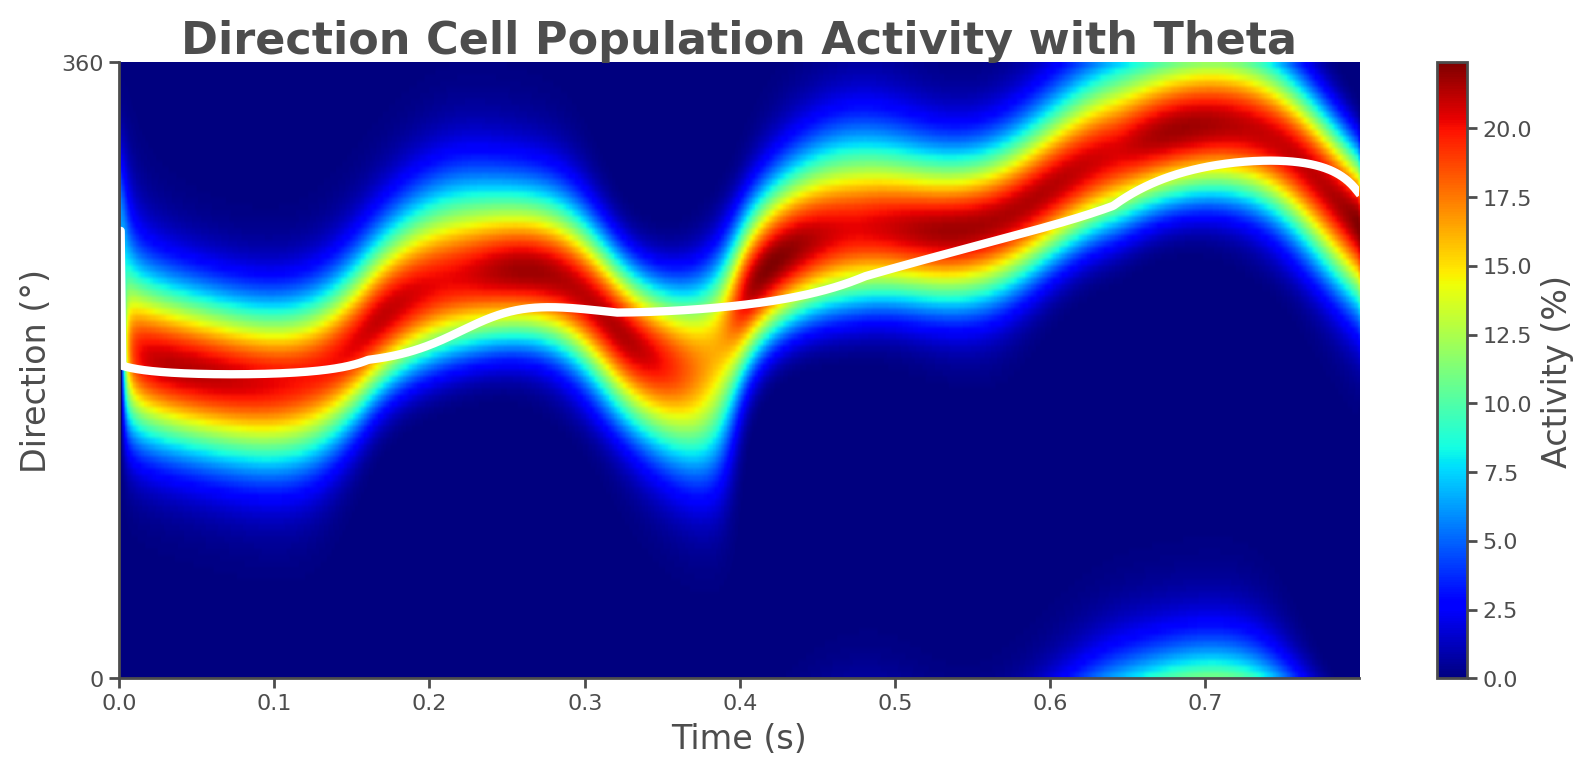

In [4]:
from canns.pipeline import ThetaSweepPipeline

pipeline = ThetaSweepPipeline(
    trajectory_data=positions,
    times=times,
    env_size=env_size,
)
results = pipeline.run(output_dir="theta_sweep_results")

![bump_analysis](../../_static/theta_sweep_animation.gif)

`results` 返回包含动画、轨迹分析以及原始仿真数据的字典，可继续交给自定义分析使用。

#### 拓展开发指南

用户可以通过继承`canns.pipeline.Pipeline`类来创建自定义的流水线。需要实现以下主要方法：

自定义流水线时：

- 继承 `canns.pipeline.Pipeline` 并实现 `run(...)`，返回包含主要产物的字典；
- 根据需要调用 `prepare_output_dir()` 管理输出目录，并用 `set_results()` 缓存结果，便于后续 `get_results()`；
- 在 `run()` 内组合模型、任务、分析器的调用顺序，保持输入输出格式清晰；
- 若有多次复用场景，可在执行前调用 `reset()` 清理上一次运行的缓存状态。